#### Import libraries

In [1]:
# magic command to use TF 1.X in colaboraty when importing tensorflow
#%tensorflow_version 1.x 
import tensorflow as tf                       # imports the tensorflow library to the python kernel
#tf.logging.set_verbosity(tf.logging.ERROR)    # sets the amount of debug information from TF (INFO, WARNING, ERROR)
import time
import random
print("Using tensorflow version:", tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() 

Using tensorflow version: 2.5.0
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
import math
pi = tf.constant(math.pi)

#### System parameters

In [3]:
print(np.version)
print("Using tensorflow version:", tf.__version__)
print(np.__version__)


<module 'numpy.version' from '/home/neelabhro/.local/lib/python3.8/site-packages/numpy/version.py'>
Using tensorflow version: 2.5.0
1.19.5


In [4]:
batch_size = 200000
########## BIT FLIPPING OFF
#print(tr)
#plt.plot(t, tr)
T1 = random.randint(1, 10)
T2 = random.randint(1, 10)
M = 256
t = np.linspace(0, 1, batch_size)
triangle1 = signal.sawtooth(T1 * np.pi * 5 * t, 0.5)
triangle1 = M/2*(triangle1)
triangle1 = triangle1.clip(min=0)

triangle2 = signal.sawtooth(T2 * np.pi * 5 * t, 0.5)
triangle2 = M/2*(triangle2)
triangle2 = triangle2.clip(min=0)

triangle3 = triangle1 + triangle2
#triangle3 = triangle3/15*(7)
tr = triangle3
bins = np.arange(M-1)
tr = np.digitize(triangle3, bins, right=True)
#plt.plot(t, triangle3)

#tr = np.flip(tr)
#print(tr)

# tr is a random uniform distribution of numbers between 1 and M, with the length of the vector being the batch size


tr = np.floor(np.random.uniform(1,M, batch_size))
#print(tr)
print(np.size(tr))
#replacements = {0:7, 1:6, 2:5, 3:4, 4:3, 5:2, 6:1, 7:0}
#replacements = {0:15, 1:14, 2:13, 3:12, 4:11, 5:10, 6:9, 7:8, 8:7, 9:6, 10:5, 11:4, 12:3, 13:2, 14:1, 15:0}
rp1 = np.arange(1,M)
rp2 = np.flip(np.arange(1,M))
replacements = dict(zip(rp1,rp2))
#print(rp2)
replacer = replacements.get
#tr = ([replacer(n, n) for n in tr])

#print(tr)

s_ind = {}
for j in range(1,M):
  s_ind[j] = [i for i, x in enumerate(tr) if x == j]
#print(s_ind)


200000


In [5]:
k = 8       # Number of information bits per message, i.e., M=2**k
n = 8       # Number of real channel uses per message
seed = 2    # Seed RNG reproduce identical results

#### The Autoencoder Class
In order to quickly experiment with different architecture and parameter choices, it is useful to create a Python class that has functions for training and inference. Each autoencoder instance has its own Tensorflow session and graph. Thus, you can have multiple instances running at the same time without interference between them.

In [6]:
f = 5.9*10**9;#in Hz corresponding to IEEE 802.11p
lamda = 0.05;  #in metres
Pt = 1; #BS transmitted power in watts

BW = 10*10**6; #in Hz
PLE = 2.8; #Path Loss exponent
Beta = {}
Pr = {}
SNR_var = {}
ad_noise_SNR = []  #The values of the dictionary, finally providing an array of stdevs
NoW = 0.02

Transmitted_Power = 20 #in dBm
Noise_val = 95 #in -dBm

noise_factor = Transmitted_Power + Noise_val
#|β| =λ/(4πD)2.31 


s = np.floor(np.random.uniform(1,M, batch_size))
s = s.astype('int64')
#s = ([replacer(n, n) for n in s])  
std_shadow = 3          
rand1 = np.random.normal(0,std_shadow,batch_size)
for i in range(batch_size):
  Beta[i] = 10*(np.log10(lamda/((4*np.pi*s[i])**PLE)))
  SNR_var[i] = Beta[i] + noise_factor + rand1[i]
#SNR_var = SNR_var + np.random.normal(0, 3, batch_size) 
  #SNR_var[i] = 10*(np.log10(np.divide((Pt*[(Beta[i])**2]),NoW)))
  #SNR_var[i] = ((M)/((s[i]+1)*4))*25   #For M=8
  #SNR_var[i] = ((M)/((s[i]+1)*4))      #For M=256

for i in SNR_var.values():
  ad_noise_SNR.append(i)
print(np.shape(ad_noise_SNR))
ad_noise_SNR = np.transpose(np.tile(ad_noise_SNR, (2,4,1)))
print(np.shape(ad_noise_SNR))

#print(np.shape(np.tile(ad_noise_SNR[7], (1000, 1, 1))))
#print(np.shape(tr[7]*np.ones(batch_size)))
rand2 = np.random.normal(0,std_shadow,batch_size)

for j in range(1,M):


  #SNR_var[j] = ((M)/((j+1)*4))*25
  #SNR_var[j] = ((M)/((j+1)*4))
  Beta[j] = 10*(np.log10(lamda/((4*np.pi*j)**2.8)))
  SNR_var[j] = Beta[j] + noise_factor + rand2[j]

const_noise_SNR = []  #The values of the dictionary, finally providing an array of stdevs
for j in SNR_var.values():
  const_noise_SNR.append(j)  
const_noise_SNR = np.transpose(np.tile(const_noise_SNR, (2,4,1)))
#print(const_noise_std)

#Choosing 15dB SNR as the constant SNR for the TB Approach
seven_noise_SNR = np.add(np.ones(batch_size)*7, np.random.normal(0,3,batch_size))

seven_noise_SNR = np.transpose(np.tile(seven_noise_SNR, (2,4,1)))
#print(np.random.normal(0,std_shadow,batch_size))

tr_noise_SNR = []
rand3 = np.random.normal(0,std_shadow,batch_size)

for i in range(batch_size):

  #SNR_var[i] = ((M)/((tr[i]+1)*4))*25
  #SNR_var[i] = ((M)/((tr[i]+1)*4))

  Beta[i] = 10*(np.log10(lamda/((4*np.pi*tr[i])**2.8)))
  SNR_var[i] = Beta[i] + noise_factor + rand3[i]
for i in SNR_var.values():
  tr_noise_SNR.append(i)

tr_noise_SNR = np.transpose(np.tile(tr_noise_SNR, (2,4,1)))
#print(s)

#print(ad_noise_SNR[7])
#print(np.tile(ad_noise_SNR[7], (1000, 1, 1)))

(200000,)
(200000, 4, 2)


In [7]:

class AE(object):
    def __init__(self, k, n, seed=None, filename=None):
        assert (n%2 == 0), "Channel only allows complex symbols -> n must be a multiple of 2"
        self.k = k 
        self.n = n
        self.n_complex = int(self.n/2)
        self.bits_per_symbol = self.k/self.n_complex
        self.M = 2**self.k
        self.seed = seed if (seed is not None) else int(time.time())           
        self.graph = None
        self.sess = None   
        self.vars = None
        self.saver = None   
        self.constellations = None
        self.blers = None
        self.create_graph()
        self.create_session()
        if filename is not None:    
            self.load(filename)       
        return
    
    
    def create_graph(self):
        '''This function creates the computation graph of the autoencoder'''
        self.graph = tf.Graph()        
        with self.graph.as_default():    
            tf.set_random_seed(self.seed)
            batch_size = tf.placeholder(tf.int32, shape=())
            
            # Transmitter
            s = (tf.random_uniform(shape=[batch_size], minval=0, maxval=self.M, dtype=tf.int64))

            ad_noise_std = tf.random_uniform(shape=[batch_size], minval=0, maxval=M, dtype=tf.int64)
            ones = tf.ones([2,4,1],dtype=tf.int64)
            ad_noise_std = tf.transpose(ad_noise_std*ones)
            #ad_noise_std = tf.transpose(tf.tile(ad_noise_std, [2,2,1]))           
            x = self.encoder(s)                         
            
            # Channel
            #noise_std = tf.placeholder(tf.float32, shape=())
            noise_std = tf.placeholder(tf.float32, shape=[200000,4,2])
            noise = tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std) 

            fade = tf.random.normal(shape=tf.shape(x))
            sparr1,sparr2 = tf.split(fade,num_or_size_splits=2, axis=2)
            complex_fade = tf.complex(sparr1, sparr2)
            fade = tf.abs(complex_fade)
            #fade = tf.math.sqrt(1/2)*fade

            fade = 1
            y = tf.multiply(x,fade) + noise
            #y = x + noise
            #fade = 1            
           
            # Receiver
            s_hat = self.decoder(y)
            correct_s_hat = tf.argmax(tf.nn.softmax(s_hat), axis=1)

            
            # Loss function
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat, weights= (s+1)**(0))

            #Defining the i_matrix
            limit = 256
            i = tf.range(limit)
            multiply = tf.constant([200000])
            i_matrix = tf.reshape(tf.tile(i, multiply), [ multiply[0], tf.shape(i)[0]])
            print(i_matrix)
            #e_si = (tf.cast(s[:, tf.newaxis], tf.float32)) - (tf.cast(i_matrix,tf.float32))
            #e_si = tf.math.square(tf.math.divide((tf.cast(s, tf.float32)) - tf.transpose(tf.cast(i_matrix,tf.float32)), tf.transpose(tf.cast(i_matrix,tf.float32))))
            e_si = tf.math.square((tf.cast(s, tf.float32)) - tf.transpose(tf.cast(i_matrix,tf.float32)))
            e_si = tf.transpose(e_si)
            b = tf.nn.softmax(s_hat)

            cost_func = tf.math.multiply(b,e_si)

            sum_cf = tf.math.multiply( tf.math.sqrt(tf.reduce_sum(cost_func, axis = 1) + 0.000001 ), (tf.cast(1/(s+ 1), tf.float32)))            
            #cross_entropy_0 = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat, weights= (s+1)**(4))
      
           # Performance metrics
            #correct_predictions_0 = tf.equal(tf.argmax(tf.nn.softmax([s_hat[x] for x in s_ind_0]), axis=1), [s[x] for x in s_ind_0])

            correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat), axis=1), s)
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            bler = 1-accuracy

            lr = tf.placeholder(tf.float32, shape=()) # We can feed in any desired learning rate for each step     
            train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
            #train_op_0 = tf.train.AdamOptimizer(lr).minimize(cross_entropy_0)
            #lr = tf.train.exponential_decay(1e-10, global_step=cross_entropy, decay_steps=100, decay_rate=1.30)

            # References to graph variables we need to access later 
            self.vars = {
                'accuracy': accuracy,
                'batch_size': batch_size,
                'bler': bler,
                'cross_entropy': cross_entropy,
                'init': tf.global_variables_initializer(),
                'lr': lr,
                'noise_std': noise_std,
                'train_op': train_op,
                #'s': (np.floor(np.random.uniform(0,256, 1000))).astype('int64'),
                's': s,
                's_hat': s_hat,
                'correct_s_hat': correct_s_hat,
                'x': x,
            }            
            self.saver = tf.train.Saver()
        return
    
    def create_session(self):
        '''Create a session for the autoencoder instance with the compuational graph'''
        self.sess = tf.Session(graph=self.graph)        
        self.sess.run(self.vars['init'])
        return
    
    def encoder(self, input):
        '''The transmitter'''
        self.weight_var_rec = self.weight_variable((self.M,self.M)) # shape = (8,8)
        self.embedding_lookup_rec = tf.nn.embedding_lookup(self.weight_var_rec, input)
        print(self.embedding_lookup_rec)
        x = tf.nn.elu(self.embedding_lookup_rec)
        #x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
        x = tf.layers.dense(x, self.M, activation=None)
        x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        x = tf.reshape(x, shape=[-1,self.n_complex,2])
        print(x);
        #Average power normalization
        x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) 
        return x
    
    def decoder(self, input):
        '''The Receiver'''
        #input = self.flip_decoder(input)
        y = tf.reshape(input, shape=[-1,self.n])
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        print(y);
        return y
    
    def EbNo2Sigma(self, ebnodb):
        '''Convert Eb/No in dB to noise standard deviation'''
        ebno = 10**(ebnodb/10)
        return 1/np.sqrt(2*self.bits_per_symbol*ebno)
    
    def gen_feed_dict(self, batch_size, ebnodb, lr):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['lr']: lr,
        }

    def gen_e2e_feed_dict(self, batch_size, ebnodb, s_input, lr):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['s']: s_input,
            self.vars['lr']: lr,
        }    
    
    def load(self, filename):
        '''Load an pre_trained model'''
        return self.saver.restore(self.sess, filename)
        
    def plot_constellation(self, noise_std, maxrange=None):
        '''Generate a plot of the current constellation'''
        x = self.transmit(range(self.M), noise_std)
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(self.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-maxrange,maxrange)
            plt.ylim(-maxrange,maxrange)
            for i in range(self.M):       
              if (i <=150):
                plt.scatter(x[i,k,0],x[i,k,1],c="black")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))  
              if (i > 150):
                plt.scatter(x[i,k,0],x[i,k,1],c="red")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))      
                #plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')  
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image
    
    def save(self, filename):
        '''Save the current model'''
        return self.saver.save(self.sess, filename)  
    
    def test_step(self, batch_size, ebnodb):
        '''Compute the BLER over a single batch and Eb/No'''
        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
        return bler
    
    def transmit(self, s, noise_std):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['x'], feed_dict={self.vars['s']: s, self.vars['noise_std']: noise_std})

    def end2end(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['correct_s_hat'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s, lr=0)) 
        #print(self.sess.run(self.vars['correct_s_hat'], feed_dict={self.vars['s']: input_s}))     

    #print(self.sess.run(self.vars['s_hat'], feed_dict={self.vars['s']: s}))
    def end2end_bler(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['bler'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s, lr=0)) 


    def train(self, training_params, validation_params):  
        
        '''Training and validation loop'''
        for index, params in enumerate(training_params):            
            s,batch_size, lr, ebnodb, iterations = params            
            print('\nBatch Size: ' + str(batch_size) +
                  ', Learning Rate: ' + str(lr) +
                  ', EbNodB: ' + str(ebnodb) +
                  ', Iterations: ' + str(iterations))
            
            val_size, val_ebnodb, val_steps = validation_params[index]
            
            for i in range(iterations):
                self.train_step(s,batch_size, ebnodb, lr)    
                if (i%val_steps==0):
                    #bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_new_feed_dict(val_size, val_ebnodb, lr, s_input))
                    bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
                    print(bler)                           
        return       
    
    def train_step(self,s, batch_size, ebnodb, lr):
        '''A single training step'''
        #self.sess.run(self.vars['train_op'], feed_dict=self.gen_new_feed_dict(batch_size, ebnodb, lr, s_input))
        self.sess.run(self.vars['train_op'], feed_dict={self.vars['s']: s, self.vars['batch_size']: batch_size,  self.vars['noise_std']: self.EbNo2Sigma(ebnodb), self.vars['lr']: lr})
        return 
    
    def weight_variable(self, shape):
        '''Xavier-initialized weights optimized for ReLU Activations'''
        (fan_in, fan_out) = shape
        low = np.sqrt(6.0/(fan_in + fan_out)) 
        high = -np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))
    
    def bler_sim(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.           
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER



    def bler_sim1(self,s,  ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.           
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
          #for ebnodb in ebnodbs:
            #print(s, batch_size, ebnodb) 
          bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_e2e_feed_dict(batch_size, np.transpose(np.tile(np.ones(1000)*ebnodb, (2,2,1))), s, lr=0)) for ebnodb in ebnodbs])
                                        
          BLER = BLER + bler/iterations
        return BLER   
    
    def plot_bler(self, EbNodB, BLER):
        '''Plot a BLER curve'''
        image = plt.figure(figsize=(10,8))
        plt.plot(EbNodB, BLER, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('Block-error rate', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5,1])
        return image

## Training parameters

In [8]:
train_EbNodB = ad_noise_SNR
val_EbNodB = train_EbNodB

lr = 0.01

epoch = [10000]

training_params = [
    #batch_size, lr, ebnodb, iterations
    [s, batch_size , 0.01, train_EbNodB, 10000]
#    [10000 , 0.001, train_EbNodB, 10000]    
    ]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000]
    ]

model_file_uw = 'models/ae_k_{}_n_{}'.format(k,n)
ae = AE(k,n,seed)
ae.train(training_params, validation_params)
ae.save(model_file_uw);
ae = AE(k,n,seed, filename=model_file_uw)
  #ae.plot_constellation();
  #ae.end2end(tr)

Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 4, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(200000, 256), dtype=float32)
Tensor("Reshape_2:0", shape=(200000, 256), dtype=int32)


/home/neelabhro/.local/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/neelabhro/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '



Batch Size: 200000, Learning Rate: 0.01, EbNodB: [[[50.26966531 50.26966531]
  [50.26966531 50.26966531]
  [50.26966531 50.26966531]
  [50.26966531 50.26966531]]

 [[14.38417412 14.38417412]
  [14.38417412 14.38417412]
  [14.38417412 14.38417412]
  [14.38417412 14.38417412]]

 [[ 7.64734018  7.64734018]
  [ 7.64734018  7.64734018]
  [ 7.64734018  7.64734018]
  [ 7.64734018  7.64734018]]

 ...

 [[10.9987172  10.9987172 ]
  [10.9987172  10.9987172 ]
  [10.9987172  10.9987172 ]
  [10.9987172  10.9987172 ]]

 [[15.48459774 15.48459774]
  [15.48459774 15.48459774]
  [15.48459774 15.48459774]
  [15.48459774 15.48459774]]

 [[16.34535622 16.34535622]
  [16.34535622 16.34535622]
  [16.34535622 16.34535622]
  [16.34535622 16.34535622]]], Iterations: 10000
0.89868
0.073994994
0.07406503
0.07345998
0.073440015
0.073454976
0.07209003
0.07172501
0.07205498
0.07301003
Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 4, 2), dtype=float32)
Tensor("de

## Create and train model

## Evaluate trained model

In [9]:
ae_uw = AE(k,n,seed, filename=model_file_uw) #Load a pretrained model that you have saved if needed

Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 4, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(200000, 256), dtype=float32)
Tensor("Reshape_2:0", shape=(200000, 256), dtype=int32)
INFO:tensorflow:Restoring parameters from models/ae_k_8_n_8


In [10]:

class AE_Weighted(object):
    def __init__(self, k, n, seed=None, filename=None):
        assert (n%2 == 0), "Channel only allows complex symbols -> n must be a multiple of 2"
        self.k = k 
        self.n = n
        self.n_complex = int(self.n/2)
        self.bits_per_symbol = self.k/self.n_complex
        self.M = 2**self.k
        self.seed = seed if (seed is not None) else int(time.time())           
        self.graph = None
        self.sess = None   
        self.vars = None
        self.saver = None   
        self.constellations = None
        self.blers = None
        self.create_graph()
        self.create_session()
        if filename is not None:    
            self.load(filename)       
        return

    
    def create_graph(self):
        '''This function creates the computation graph of the autoencoder'''
        self.graph = tf.Graph()        
        with self.graph.as_default():    
            tf.set_random_seed(self.seed)
            batch_size = tf.placeholder(tf.int32, shape=())
            
            # Transmitter
            s = (tf.random_uniform(shape=[batch_size], minval=0, maxval=self.M, dtype=tf.int64))

            ad_noise_std = tf.random_uniform(shape=[batch_size], minval=0, maxval=M, dtype=tf.int64)
            ones = tf.ones([2,4,1],dtype=tf.int64)
            ad_noise_std = tf.transpose(ad_noise_std*ones)
            x = self.encoder(s) 

                         
            
            # Channel
            #noise_std = tf.placeholder(tf.float32, shape=())
            noise_std = tf.placeholder(tf.float32, shape=[200000,4,2])
            noise = tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std) 

            fade = tf.random.normal(shape=tf.shape(x))
            sparr1,sparr2 = tf.split(fade,num_or_size_splits=2, axis=2)
            complex_fade = tf.complex(sparr1, sparr2)
            fade = tf.abs(complex_fade)
            #fade = tf.math.sqrt(1/2)*fade

            fade = 1
            y = tf.multiply(x,fade) + noise
            #y = x + noise
            #fade = 1            
           
            # Receiver
            s_hat = self.decoder(y)
            correct_s_hat = tf.argmax(tf.nn.softmax(s_hat), axis=1)

            
           # Loss function
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat, weights= (s+1)**(1))

            #Defining the i_matrix
            limit = 256
            i = tf.range(limit)
            multiply = tf.constant([200000])
            i_matrix = tf.reshape(tf.tile(i, multiply), [ multiply[0], tf.shape(i)[0]])
            print(i_matrix)
            #e_si = (tf.cast(s[:, tf.newaxis], tf.float32)) - (tf.cast(i_matrix,tf.float32))
            #e_si = tf.math.square(tf.math.divide((tf.cast(s, tf.float32)) - tf.transpose(tf.cast(i_matrix,tf.float32)), tf.transpose(tf.cast(i_matrix,tf.float32))))
            e_si = tf.math.square((tf.cast(s, tf.float32)) - tf.transpose(tf.cast(i_matrix,tf.float32)))
            e_si = tf.transpose(e_si)
            b = tf.nn.softmax(s_hat)

            cost_func = tf.math.multiply(b,e_si)

            sum_cf = tf.math.multiply( tf.math.sqrt(tf.reduce_sum(cost_func, axis = 1) + 0.000001 ), (tf.cast(1/(s+ 1), tf.float32)))            
            #cross_entropy_0 = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat, weights= (s+1)**(4))
      
           # Performance metrics
            #correct_predictions_0 = tf.equal(tf.argmax(tf.nn.softmax([s_hat[x] for x in s_ind_0]), axis=1), [s[x] for x in s_ind_0])

            correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat), axis=1), s)
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            bler = 1-accuracy

            lr = tf.placeholder(tf.float32, shape=()) # We can feed in any desired learning rate for each step     
            train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy + sum_cf)
            # References to graph variables we need to access later 
            self.vars = {
                'accuracy': accuracy,
                'batch_size': batch_size,
                'bler': bler,
                'cross_entropy': cross_entropy,
                'init': tf.global_variables_initializer(),
                'lr': lr,
                'noise_std': noise_std,
                'train_op': train_op,
                's': s,
                's_hat': s_hat,
                'correct_s_hat': correct_s_hat,
                'x': x,
            }            
            self.saver = tf.train.Saver()
        return
    
    
    def create_session(self):
        '''Create a session for the autoencoder instance with the compuational graph'''
        self.sess = tf.Session(graph=self.graph)        
        self.sess.run(self.vars['init'])
        return
    
    def encoder(self, input):
        '''The transmitter'''
        self.weight_var_rec = self.weight_variable((self.M,self.M)) # shape = (8,8)
        self.embedding_lookup_rec = tf.nn.embedding_lookup(self.weight_var_rec, input)
        print(self.embedding_lookup_rec)
        x = tf.nn.elu(self.embedding_lookup_rec)
        #x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
        x = tf.layers.dense(x, self.M, activation=None)
        x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        x = tf.reshape(x, shape=[-1,self.n_complex,2])
        print(x);
        #Average power normalization
        x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) 
        return x
    
    def decoder(self, input):
        '''The Receiver'''
        #input = self.flip_decoder(input)
        y = tf.reshape(input, shape=[-1,self.n])
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        print(y);
        return y
    
    def EbNo2Sigma(self, ebnodb):
        '''Convert Eb/No in dB to noise standard deviation'''
        ebno = 10**(ebnodb/10)
        return 1/np.sqrt(2*self.bits_per_symbol*ebno)
    
    def gen_feed_dict(self, batch_size, ebnodb, lr):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['lr']: lr,
        }

    def gen_e2e_feed_dict(self, batch_size, ebnodb, s_input, lr):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['s']: s_input,
            self.vars['lr']: lr,
        }    
    
    def load(self, filename):
        '''Load an pre_trained model'''
        return self.saver.restore(self.sess, filename)
        
    def plot_constellation(self,noise_std, maxrange=None):
        '''Generate a plot of the current constellation'''
        x = self.transmit(range(self.M), noise_std)
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(self.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-maxrange,maxrange)
            plt.ylim(-maxrange,maxrange)
            for i in range(self.M):       
              if (i <=150):
                plt.scatter(x[i,k,0],x[i,k,1],c="black")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))  
              if (i > 150):
                plt.scatter(x[i,k,0],x[i,k,1],c="red")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))      
                #plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')   
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image
    
    def save(self, filename):
        '''Save the current model'''
        return self.saver.save(self.sess, filename)  
    
    def test_step(self, batch_size, ebnodb):
        '''Compute the BLER over a single batch and Eb/No'''
        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
        return bler
    
    def transmit(self, s, noise_std):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['x'], feed_dict={self.vars['s']: s, self.vars['noise_std']: noise_std})

    def end2end(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['correct_s_hat'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s, lr=0)) 
        #print(self.sess.run(self.vars['correct_s_hat'], feed_dict={self.vars['s']: input_s}))     

    def end2end_bler(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['bler'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s, lr=0)) 

    def train(self, training_params, validation_params):  
        
        '''Training and validation loop'''
        for index, params in enumerate(training_params):            
            s,batch_size, lr, ebnodb, iterations = params            
            print('\nBatch Size: ' + str(batch_size) +
                  ', Learning Rate: ' + str(lr) +
                  ', EbNodB: ' + str(ebnodb) +
                  ', Iterations: ' + str(iterations))
            
            val_size, val_ebnodb, val_steps = validation_params[index]
            
            for i in range(iterations):
                self.train_step(s,batch_size, ebnodb, lr)    
                if (i%val_steps==0):
                    #bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_new_feed_dict(val_size, val_ebnodb, lr, s_input))
                    bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
                    print(bler)                           
        return       
    
    def train_step(self,s, batch_size, ebnodb, lr):
        '''A single training step'''
        #self.sess.run(self.vars['train_op'], feed_dict=self.gen_new_feed_dict(batch_size, ebnodb, lr, s_input))
        self.sess.run(self.vars['train_op'], feed_dict={self.vars['s']: s, self.vars['batch_size']: batch_size,  self.vars['noise_std']: self.EbNo2Sigma(ebnodb), self.vars['lr']: lr})
        return 
    
    def weight_variable(self, shape):
        '''Xavier-initialized weights optimized for ReLU Activations'''
        (fan_in, fan_out) = shape
        low = np.sqrt(6.0/(fan_in + fan_out)) 
        high = -np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))
    
    def bler_sim(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.           
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER



    def bler_sim1(self,s,  ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.           
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
          #for ebnodb in ebnodbs:
            #print(s, batch_size, ebnodb) 
          bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_e2e_feed_dict(batch_size, np.transpose(np.tile(np.ones(1000)*ebnodb, (2,2,1))), s, lr=0)) for ebnodb in ebnodbs])
                                        
          BLER = BLER + bler/iterations
        return BLER        
    
    def plot_bler(self, EbNodB, BLER):
        '''Plot a BLER curve'''
        image = plt.figure(figsize=(10,8))
        plt.plot(EbNodB, BLER, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('Block-error rate', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5,1])
        return image

In [11]:
train_EbNodB = ad_noise_SNR
val_EbNodB = train_EbNodB

lr = 0.01

epoch = [10000]

training_params = [
    #batch_size, lr, ebnodb, iterations
    [s, batch_size , 0.01, train_EbNodB, 10000]
#    [10000 , 0.001, train_EbNodB, 10000]    
    ]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000]
    ]

model_file = 'models/ae_k_{}_n_{}'.format(k,n)
ae_Weighted = AE_Weighted(k,n,seed)
ae_Weighted.train(training_params, validation_params)
ae_Weighted.save(model_file);
ae_Weighted = AE_Weighted(k,n,seed, filename=model_file)

Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 4, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(200000, 256), dtype=float32)
Tensor("Reshape_2:0", shape=(200000, 256), dtype=int32)

Batch Size: 200000, Learning Rate: 0.01, EbNodB: [[[50.26966531 50.26966531]
  [50.26966531 50.26966531]
  [50.26966531 50.26966531]
  [50.26966531 50.26966531]]

 [[14.38417412 14.38417412]
  [14.38417412 14.38417412]
  [14.38417412 14.38417412]
  [14.38417412 14.38417412]]

 [[ 7.64734018  7.64734018]
  [ 7.64734018  7.64734018]
  [ 7.64734018  7.64734018]
  [ 7.64734018  7.64734018]]

 ...

 [[10.9987172  10.9987172 ]
  [10.9987172  10.9987172 ]
  [10.9987172  10.9987172 ]
  [10.9987172  10.9987172 ]]

 [[15.48459774 15.48459774]
  [15.48459774 15.48459774]
  [15.48459774 15.48459774]
  [15.48459774 15.48459774]]

 [[16.34535622 16.34535622]
  [16.34535622 16.34535622]
  [16.34535622 16.34535622]
  [16.34535622 16.34535622]]], Iterations: 10000


In [15]:

class AE_Tb(object):
    def __init__(self, k, n, seed=None, filename=None):
        assert (n%2 == 0), "Channel only allows complex symbols -> n must be a multiple of 2"
        self.k = k 
        self.n = n
        self.n_complex = int(self.n/2)
        self.bits_per_symbol = self.k/self.n_complex
        self.M = 2**self.k
        self.seed = seed if (seed is not None) else int(time.time())           
        self.graph = None
        self.sess = None   
        self.vars = None
        self.saver = None   
        self.constellations = None
        self.blers = None
        self.create_graph()
        self.create_session()
        if filename is not None:    
            self.load(filename)       
        return
    
    
    def create_graph(self):
        '''This function creates the computation graph of the autoencoder'''
        self.graph = tf.Graph()        
        with self.graph.as_default():    
            tf.set_random_seed(self.seed)
            batch_size = tf.placeholder(tf.int32, shape=())
            
            # Transmitter
            s = (tf.random_uniform(shape=[batch_size], minval=0, maxval=self.M, dtype=tf.int64))

            ad_noise_std = tf.random_uniform(shape=[batch_size], minval=0, maxval=M, dtype=tf.int64)
            ones = tf.ones([2,4,1],dtype=tf.int64)
            ad_noise_std = tf.transpose(ad_noise_std*ones)
            #ad_noise_std = tf.transpose(tf.tile(ad_noise_std, [2,2,1]))           
            x = self.encoder(s)                         
            
            # Channel
            #noise_std = tf.placeholder(tf.float32, shape=())
            noise_std = tf.placeholder(tf.float32, shape=[200000,4,2])
            noise = tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std) 

            fade = tf.random.normal(shape=tf.shape(x))
            sparr1,sparr2 = tf.split(fade,num_or_size_splits=2, axis=2)
            complex_fade = tf.complex(sparr1, sparr2)
            fade = tf.abs(complex_fade)
            #fade = tf.math.sqrt(1/2)*fade

            fade = 1
            y = tf.multiply(x,fade) + noise
            #y = x + noise
       
           
            # Receiver
            s_hat = self.decoder(y)
            correct_s_hat = tf.argmax(tf.nn.softmax(s_hat), axis=1)

            
            # Loss function
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            #cross_entropy_0 = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
            #cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat, weights= (s+1)**(4))
      
           # Performance metrics
            #correct_predictions_0 = tf.equal(tf.argmax(tf.nn.softmax([s_hat[x] for x in s_ind_0]), axis=1), [s[x] for x in s_ind_0])

            correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat), axis=1), s)
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            bler = 1-accuracy

            lr = tf.placeholder(tf.float32, shape=()) # We can feed in any desired learning rate for each step     
            train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
            #train_op_0 = tf.train.AdamOptimizer(lr).minimize(cross_entropy_0)
            #lr = tf.train.exponential_decay(1e-10, global_step=cross_entropy, decay_steps=100, decay_rate=1.30)

            # References to graph variables we need to access later 
            self.vars = {
                'accuracy': accuracy,
                'batch_size': batch_size,
                'bler': bler,
                'cross_entropy': cross_entropy,
                'init': tf.global_variables_initializer(),
                'lr': lr,
                'noise_std': noise_std,
                'train_op': train_op,
                #'s': (np.floor(np.random.uniform(0,256, 1000))).astype('int64'),
                's': s,
                's_hat': s_hat,
                'correct_s_hat': correct_s_hat,
                'x': x,
            }            
            self.saver = tf.train.Saver()
        return
    
    def create_session(self):
        '''Create a session for the autoencoder instance with the compuational graph'''
        self.sess = tf.Session(graph=self.graph)        
        self.sess.run(self.vars['init'])
        return
    
    def encoder(self, input):
        '''The transmitter'''
        self.weight_var_rec = self.weight_variable((self.M,self.M)) # shape = (8,8)
        self.embedding_lookup_rec = tf.nn.embedding_lookup(self.weight_var_rec, input)
        print(self.embedding_lookup_rec)
        x = tf.nn.elu(self.embedding_lookup_rec)
        #x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
        x = tf.layers.dense(x, self.M, activation=None)
        x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        #x = tf.layers.dense(x, self.n, activation=None)
        x = tf.reshape(x, shape=[-1,self.n_complex,2])
        print(x);
        #Average power normalization
        x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) 
        return x
    
    def decoder(self, input):
        '''The Receiver'''
        #input = self.flip_decoder(input)
        y = tf.reshape(input, shape=[-1,self.n])
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        #y = tf.layers.dense(y, self.M, activation=None)
        print(y);
        return y
    
    def EbNo2Sigma(self, ebnodb):
        '''Convert Eb/No in dB to noise standard deviation'''
        ebno = 10**(ebnodb/10)
        return 1/np.sqrt(2*self.bits_per_symbol*ebno)
    
    def gen_feed_dict(self, batch_size, ebnodb, lr):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['lr']: lr,
        }

    def gen_e2e_feed_dict(self, batch_size, ebnodb, s_input, lr):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['s']: s_input,
            self.vars['lr']: lr,
        }   
    
    def load(self, filename):
        '''Load an pre_trained model'''
        return self.saver.restore(self.sess, filename)
        
    def plot_constellation(self, noise_std, maxrange=None):
        '''Generate a plot of the current constellation'''
        x = self.transmit(range(self.M), noise_std)
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(self.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-maxrange,maxrange)
            plt.ylim(-maxrange,maxrange)
            for i in range(self.M):
              if (i <=150):
                plt.scatter(x[i,k,0],x[i,k,1],c="black")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))  
              if (i > 150):
                plt.scatter(x[i,k,0],x[i,k,1],c="red")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))      
                #plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')   
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image
    
    def save(self, filename):
        '''Save the current model'''
        return self.saver.save(self.sess, filename)  
    
    def test_step(self, batch_size, ebnodb):
        '''Compute the BLER over a single batch and Eb/No'''
        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
        return bler
    
    def transmit(self, s, noise_std):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['x'], feed_dict={self.vars['s']: s, self.vars['noise_std']: noise_std})

    def end2end(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['correct_s_hat'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s, lr=0)) 
        #print(self.sess.run(self.vars['correct_s_hat'], feed_dict={self.vars['s']: input_s}))     

    def end2end_bler(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['bler'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s, lr=0))

    def train(self, training_params, validation_params):  
        
        '''Training and validation loop'''
        for index, params in enumerate(training_params):            
            s,batch_size, lr, ebnodb, iterations = params            
            print('\nBatch Size: ' + str(batch_size) +
                  ', Learning Rate: ' + str(lr) +
                  ', EbNodB: ' + str(ebnodb) +
                  ', Iterations: ' + str(iterations))
            
            val_size, val_ebnodb, val_steps = validation_params[index]
            
            for i in range(iterations):
                self.train_step(s,batch_size, ebnodb, lr)    
                if (i%val_steps==0):
                    #bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_new_feed_dict(val_size, val_ebnodb, lr, s_input))
                    bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
                    print(bler)                           
        return       
    
    def train_step(self,s, batch_size, ebnodb, lr):
        '''A single training step'''
        #self.sess.run(self.vars['train_op'], feed_dict=self.gen_new_feed_dict(batch_size, ebnodb, lr, s_input))
        self.sess.run(self.vars['train_op'], feed_dict={self.vars['s']: s, self.vars['batch_size']: batch_size,  self.vars['noise_std']: self.EbNo2Sigma(ebnodb), self.vars['lr']: lr})
        return 
    
    def weight_variable(self, shape):
        '''Xavier-initialized weights optimized for ReLU Activations'''
        (fan_in, fan_out) = shape
        low = np.sqrt(6.0/(fan_in + fan_out)) 
        high = -np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))
    
    def bler_sim(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.           
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER

    def bler_sim1(self,s,  ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.           
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
          #for ebnodb in ebnodbs:
            #print(s, batch_size, ebnodb) 
          bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_e2e_feed_dict(batch_size, np.transpose(np.tile(np.ones(1000)*ebnodb, (2,2,1))), s, lr=0)) for ebnodb in ebnodbs])
                                        
          BLER = BLER + bler/iterations
        return BLER   


    def plot_bler(self, EbNodB, BLER):
        '''Plot a BLER curve'''
        image = plt.figure(figsize=(10,8))
        plt.plot(EbNodB, BLER, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('Block-error rate', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5,1])
        return image

In [16]:
train_EbNodB = seven_noise_SNR
val_EbNodB = train_EbNodB

lr = 0.01

epoch = [10000]

training_params = [
    #batch_size, lr, ebnodb, iterations
    [s, batch_size , 0.01, train_EbNodB, 10000]
    #[s, 1000 , 0.001, train_EbNodB, 10000]
    #[1000 , 0.001, train_EbNodB, 10000]    
    ]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000]
    ]

model_file_Tb = 'models/ae_k_{}_n_{}'.format(k,n)
ae_Tb = AE_Tb(k,n,seed)
ae_Tb.train(training_params, validation_params)
ae_Tb.save(model_file_Tb);
ae_Tb = AE_Tb(k,n,seed, filename=model_file_Tb)  #ae.plot_constellation();
  #ae.end2end(tr)

Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 4, 2), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(200000, 256), dtype=float32)

Batch Size: 200000, Learning Rate: 0.01, EbNodB: [[[ 6.58104672  6.58104672]
  [ 6.58104672  6.58104672]
  [ 6.58104672  6.58104672]
  [ 6.58104672  6.58104672]]

 [[ 8.29166908  8.29166908]
  [ 8.29166908  8.29166908]
  [ 8.29166908  8.29166908]
  [ 8.29166908  8.29166908]]

 [[ 7.11233156  7.11233156]
  [ 7.11233156  7.11233156]
  [ 7.11233156  7.11233156]
  [ 7.11233156  7.11233156]]

 ...

 [[ 6.09230861  6.09230861]
  [ 6.09230861  6.09230861]
  [ 6.09230861  6.09230861]
  [ 6.09230861  6.09230861]]

 [[10.60364056 10.60364056]
  [10.60364056 10.60364056]
  [10.60364056 10.60364056]
  [10.60364056 10.60364056]]

 [[14.9047518  14.9047518 ]
  [14.9047518  14.9047518 ]
  [14.9047518  14.9047518 ]
  [14.9047518  14.9047518 ]]], Iterations: 10000
0.907355
0.031064987
0.031729996
0.031050026
0.02965498


### Plot of learned constellations

(array([[[ 2.43286742e-03,  2.86554126e-03],
         [-1.07996422e-03,  1.71804801e-02],
         [ 2.46143304e-02,  3.68951773e-03],
         [ 1.45033759e-03, -5.34046115e-03]],
 
        [[ 3.51959109e-01,  4.29968089e-01],
         [-3.60653877e-01,  4.86561626e-01],
         [-9.55338851e-02,  1.13909282e-01],
         [-2.04227775e-01, -4.14036252e-02]],
 
        [[ 1.71653926e-01,  1.51951477e-01],
         [ 7.20975757e-01, -2.67309755e-01],
         [-1.14896394e-01, -1.35156229e-01],
         [ 9.86690447e-02,  3.16491038e-01]],
 
        ...,
 
        [[-1.17160000e-01,  1.54475737e+00],
         [-1.17325842e+00,  1.97419986e-01],
         [ 1.98350668e-01,  1.08080399e+00],
         [ 7.05988169e-01,  2.60086155e+00]],
 
        [[ 1.03616285e+00,  2.04919267e+00],
         [ 1.21671152e+00,  6.01872146e-01],
         [-1.60079491e+00,  6.07610762e-01],
         [ 1.30617106e+00,  3.67214292e-01]],
 
        [[-1.89227641e+00,  5.31474948e-01],
         [-6.25521541e-01

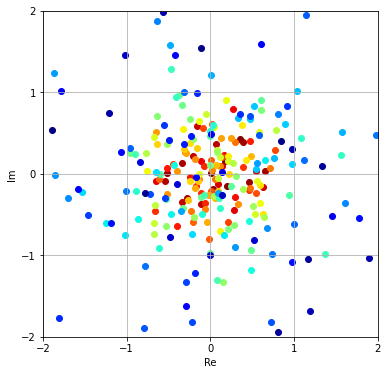

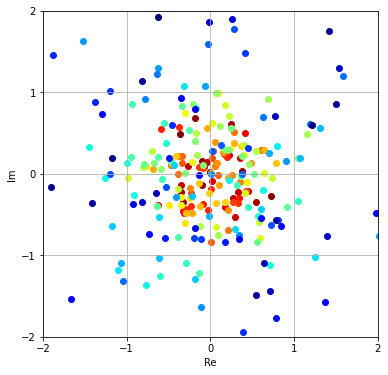

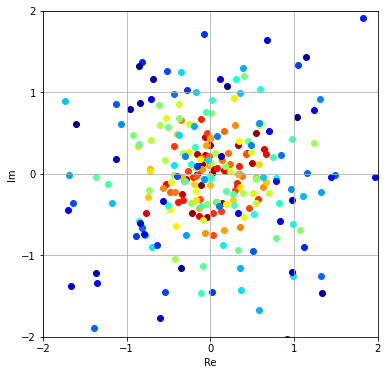

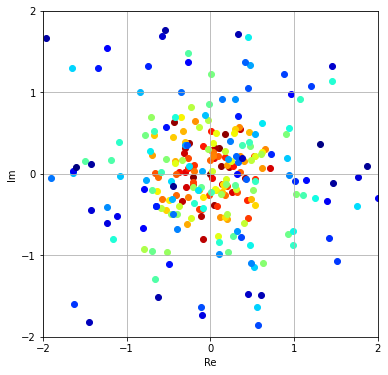

In [17]:
import matplotlib.cm as cm
import itertools
def plot_constellation_2(ae, arr, noise_std,  maxrange=None):
        '''Generate a plot of the current constellation'''
        x = ae.transmit(range(ae.M), noise_std)
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(ae.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-2,2)
            plt.ylim(-2,2)
            for i in range(ae.M):
              plt.scatter(x[i,k,0],x[i,k,1],color=cm.jet_r(i/255.0))
              #if (i <=150):
                #plt.scatter(x[i,k,0],x[i,k,1],c="black")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))  
              #if (i > 150):
                #plt.scatter(x[i,k,0],x[i,k,1],c="red")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))      
                #plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')   
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            #image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image

plot_constellation_2(ae,range(0,ae.M), const_noise_SNR)

**THE RMSE Calculations**

{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 3.384234874425708, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.8443170536763502, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 1.9020688749261367, 94: 0.0, 95: 4.166855011073872, 96: 1.2865350418053538, 97: 0.0, 98: 0.0, 99: 0.0, 100: 4.09279522608277, 101: 1.08180150408388

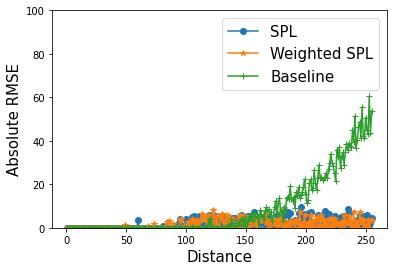

In [18]:
def rmse(predictions,targets):
  return (np.sqrt((np.subtract(predictions,targets) ** 2).mean()))   

iter = 10
rmse_uw = {}
rmse_w = {}
rmse_Tb = {}
sum_uw = {}
sum_w = {}
sum_Tb = {}
sum_uw[0] = 0
#for i in range(1,iter):





tr_hat = ae.end2end(len(tr), tr_noise_SNR, tr)
tr_hat_w = ae_Weighted.end2end(len(tr), tr_noise_SNR, tr)
tr_hat_Tb = ae_Tb.end2end(len(tr), tr_noise_SNR, tr)

#print(abs(tr_hat - tr))

for j in range(1,M):
#    rmse_uw[j,i] = rmse(([tr_hat[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
  rmse_uw[j] = rmse(([tr_hat[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
for j in range(1,M):
 #   rmse_w[j,i] = rmse(([tr_hat_w[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
 rmse_w[j] = rmse(([tr_hat_w[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
for j in range(1,M):
#    rmse_Tb[j,i] = rmse(([tr_hat_Tb[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
  rmse_Tb[j] = rmse(([tr_hat_Tb[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
  #sum_uw[i] = sum_uw[i] + sum_uw[i-1]

print(rmse_uw)
message_factor = (np.arange(1, M))

rmse_uwA = []
for i in rmse_uw.values():
  rmse_uwA.append(i)

rmse_wA = []
for i in rmse_w.values():
  rmse_wA.append(i)

rmse_TbA = []
for i in rmse_Tb.values():
  rmse_TbA.append(i)

#rmse_uw = np.log2(np.divide(rmse_uwA,message_factor) +1)
#rmse_uw = (np.divide(rmse_uwA,message_factor) +1)
rmse_uw = rmse_uwA

#rmse_w = np.log2(np.divide(rmse_wA,message_factor) + 1)
#rmse_w = (np.divide(rmse_wA,message_factor) + 1)
rmse_w = rmse_wA


#rmse_Tb = np.log2(np.divide(rmse_TbA,message_factor) +1)
#rmse_Tb = (np.divide(rmse_TbA,message_factor))
rmse_Tb = rmse_TbA

message = np.arange(1,M)

print(rmse_uw)
plt.plot(message, rmse_uw, '-o');
plt.plot(message, rmse_w, '-*');
plt.plot(message, rmse_Tb, '-+');
plt.xlabel('Distance',fontsize=15)
plt.ylabel('Absolute RMSE',fontsize=15)
plt.ylim([0, 100])
#plt.ylabel('log2 Norm RMSE deviation')
plt.legend(['SPL', 'Weighted SPL','Baseline'],fontsize=15)
#plt.legend(['Mixed LF', 'Cross Entropy','TB with CE'])
plt.rcParams.update({'font.size': 15})

print(np.sum(rmse_uw))
print(np.sum(rmse_w))
print(np.sum(rmse_Tb))
#print(np.sum(rmse_uwA))
#print(np.sum(rmse_wA))

{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0012886597938144284, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0013054830287205776, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0013495276653171517, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0012547051442910462, 85: 0.0, 86: 0.0013089005235602524, 87: 0.0, 88: 0.0, 89: 0.001322751322751281, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.003942181340341633, 96: 0.003831417624521105, 97:

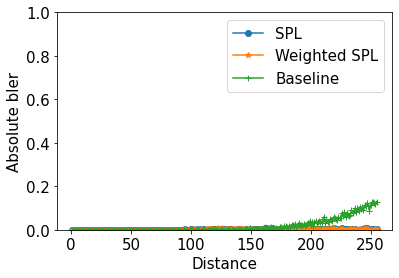

In [19]:
def nsj_bler(predictions,targets):
  return 1 - (((np.equal(predictions,targets)).mean()))   

iter = 10
bler_uw = {}
bler_w = {}
bler_Tb = {}
sum_uw = {}
sum_w = {}
sum_Tb = {}



for j in range(1,M):
#    rmse_uw[j,i] = rmse(([tr_hat[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
  bler_uw[j] = nsj_bler(([tr_hat[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
for j in range(1,M):
 #   rmse_w[j,i] = rmse(([tr_hat_w[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
  bler_w[j] = nsj_bler(([tr_hat_w[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
for j in range(1,M):
#    rmse_Tb[j,i] = rmse(([tr_hat_Tb[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
  bler_Tb[j] = nsj_bler(([tr_hat_Tb[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
  #sum_uw[i] = sum_uw[i] + sum_uw[i-1]

print(bler_w)
message_factor = (np.arange(1, M))

bler_uwA = []
for i in bler_uw.values():
  bler_uwA.append(i)

bler_wA = []
for i in bler_w.values():
  bler_wA.append(i)

bler_TbA = []
for i in bler_Tb.values():
  bler_TbA.append(i)

#rmse_uw = np.log2(np.divide(rmse_uwA,message_factor) +1)
#rmse_uw = (np.divide(rmse_uwA,message_factor) +1)
bler_uw = bler_uwA

#rmse_w = np.log2(np.divide(rmse_wA,message_factor) + 1)
#rmse_w = (np.divide(rmse_wA,message_factor) + 1)
bler_w = bler_wA


#rmse_Tb = np.log2(np.divide(rmse_TbA,message_factor) +1)
#rmse_Tb = (np.divide(rmse_TbA,message_factor))
bler_Tb = bler_TbA
bler_w[0] = 0
message = np.arange(1,M)

#print(bler_uw)
plt.plot(message, bler_uw, '-o');
plt.plot(message, bler_w, '-*');
plt.plot(message, bler_Tb, '-+');
plt.xlabel('Distance',fontsize=15)
plt.ylabel('Absolute bler',fontsize=15)
plt.ylim([0, 1])
#plt.ylabel('log2 Norm RMSE deviation')
plt.legend(['SPL', 'Weighted SPL','Baseline'],fontsize=15)
#plt.legend(['Mixed LF', 'Cross Entropy','TB with CE'])
plt.rcParams.update({'font.size': 15})

print(np.sum(bler_uw))
print(np.sum(bler_w))
print(np.sum(bler_Tb))
#print(np.sum(rmse_uwA))
#print(np.sum(rmse_wA))
#np.save('bler_w_100mW.npy',bler_w)

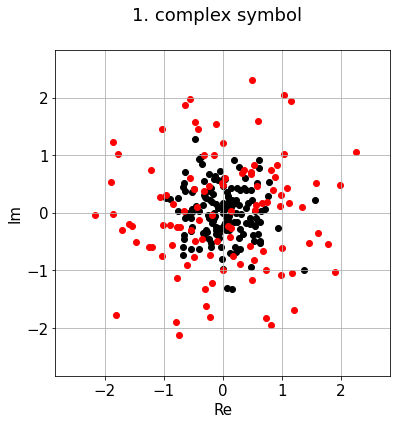

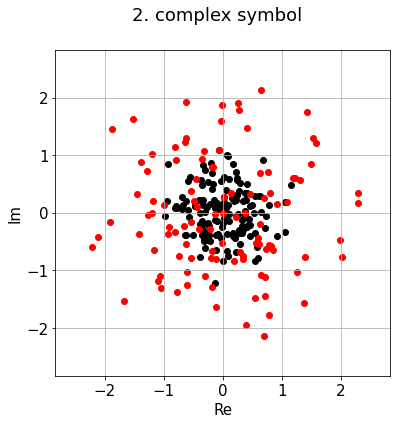

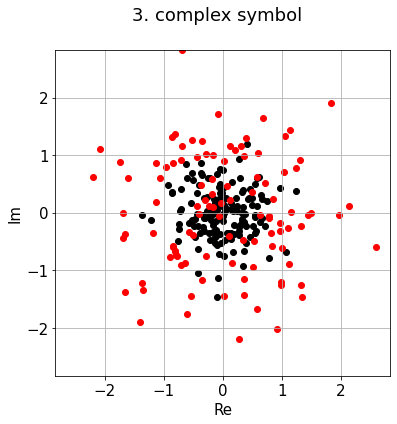

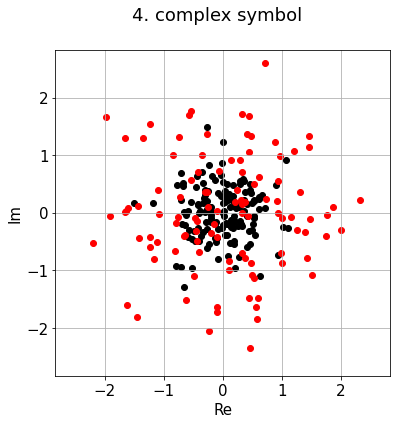

In [20]:
ae.plot_constellation(const_noise_SNR);
#plot_constellation_2(ae,range(0,ae.M))

(array([[[-3.59186815e-04,  1.59600060e-02],
         [ 1.26802363e-03,  1.99356209e-02],
         [ 1.73436441e-02,  1.70588177e-02],
         [-7.44742574e-04,  2.82786181e-03]],
 
        [[ 1.06232502e-01,  1.56061798e-01],
         [-4.75191418e-03, -2.06442527e-03],
         [-2.46773317e-01,  8.91128778e-01],
         [ 3.90894413e-02,  6.13966957e-02]],
 
        [[-7.48977438e-02,  5.85029498e-02],
         [-7.85731971e-02,  1.04679324e-01],
         [-5.03055930e-01,  7.06221581e-01],
         [-1.10983633e-01, -3.00330311e-01]],
 
        ...,
 
        [[ 1.73853493e+00,  5.41348100e-01],
         [-2.02644277e+00,  2.75114626e-01],
         [-5.17316520e-01,  1.52026042e-01],
         [ 2.66176850e-01,  2.28057528e+00]],
 
        [[ 1.60318470e+00, -2.28742838e-01],
         [ 2.46832323e+00,  1.76326776e+00],
         [ 1.51632562e-01,  6.18253350e-01],
         [ 1.67546064e-01, -2.75112689e-01]],
 
        [[-2.40107250e+00,  1.06555581e+00],
         [-1.33046913e+00

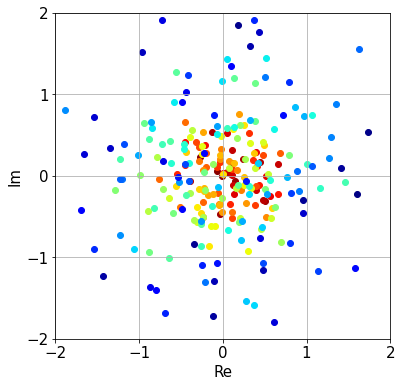

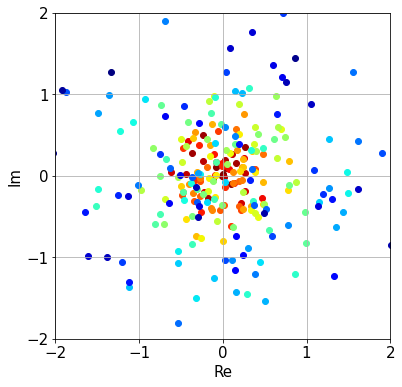

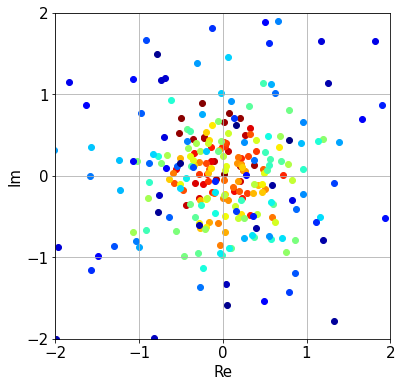

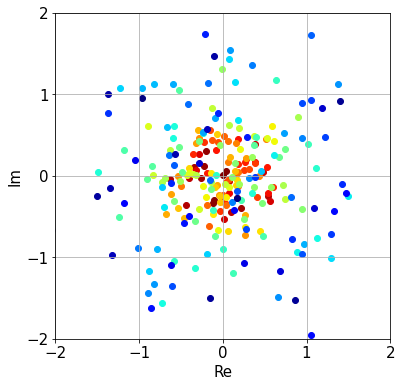

In [21]:
plot_constellation_2(ae_Weighted,range(0,ae_Weighted.M), const_noise_SNR)

(array([[[ 5.9002880e-03,  1.1919006e-02],
         [-1.0666657e-02,  8.2013197e-03],
         [ 1.4720336e-02,  1.2542486e-02],
         [-1.6320396e-03,  3.1095031e-03]],
 
        [[-7.2525913e-01, -4.2509043e-01],
         [-8.2374710e-01,  3.4060320e-01],
         [-8.0212659e-01, -8.8156573e-02],
         [ 3.1256524e-01, -1.3007077e+00]],
 
        [[ 7.0296359e-01, -4.7125936e-01],
         [ 1.0475585e+00, -4.0876114e-01],
         [ 3.5559377e-01, -2.2092073e-01],
         [-5.6674230e-01, -1.2104831e+00]],
 
        ...,
 
        [[-1.1861031e-01,  3.9114049e-01],
         [ 1.1480945e+00, -5.1233745e-01],
         [-4.7147521e-01,  5.7090896e-01],
         [ 2.0848645e-01,  1.3128662e+00]],
 
        [[ 3.1331804e-01,  1.3652313e-01],
         [ 1.8355870e-01,  1.7965306e+00],
         [ 9.3308249e-03,  6.6767305e-01],
         [-4.4340846e-01, -6.7666665e-02]],
 
        [[-1.3167166e+00,  1.1430314e+00],
         [-2.3304968e-01,  3.7781173e-01],
         [ 2.0785911e-01

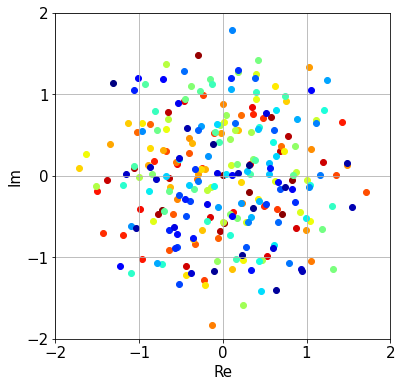

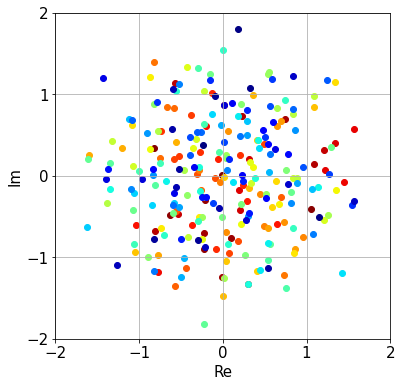

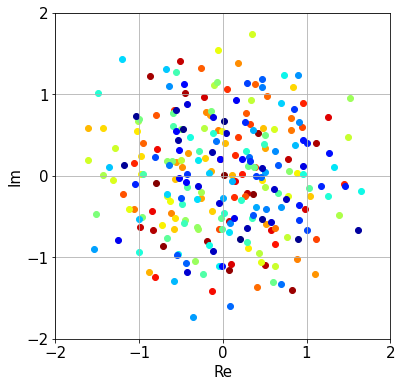

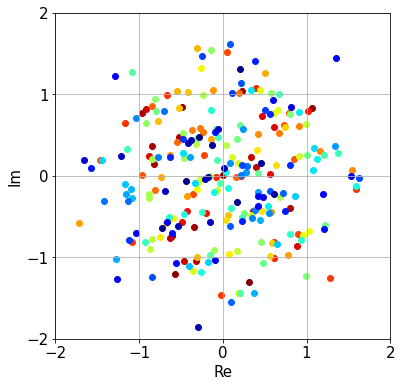

In [22]:
plot_constellation_2(ae_Tb,range(0,ae_Tb.M), const_noise_SNR)

### BLER Simulations

In [23]:
#IEEE 802.11p Max TX Power 30dBm
#Path loss model corresponding: 20log10(d(m))  (We take n=2, FSPL)
#0.1W corresponds to 20dBm or -10dB
#7dB corresponds to 5W
#IEEE 802.11p is an approved amendment to the IEEE 802.11 standard to add wireless access in vehicular environments (WAVE), a vehicular communication system. 
#IEEE 802.11p standard typically uses channels of 10 MHz bandwidth in the 5.9 GHz band (5.850–5.925 GHz).
# Noise Power -100dBm, TX Power is 20dBm and that \
#256m- -94dBm, 128m- -88dBm, 1m
#2.8 Path loss exponent, -63dB at 5m, 20dBm TX Power, -95dBm NOise figure, net 52dB SNR at 5m distance

In [24]:
np.save('bler_w_100mW_n4.npy',bler_w)
np.save('bler_uw_100mW_n4.npy',bler_uw)
np.save('bler_Tb_100mW_n4.npy',bler_Tb)

np.save('rmse_w_100mW_n4.npy',rmse_w)
np.save('rmse_uw_100mW_n4.npy',rmse_uw)
np.save('rmse_Tb_100mW_n4.npy',rmse_Tb)